In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel


In [2]:
def diff_eq(t, y):
    return 0.9*y**2*np.cos(t)

def y_sol(ts, t0=0.0, y0=1.0):
    return 10.0*y0/(10.0-9.0*y0*(np.sin(ts) - np.sin(t0)))

In [3]:
class Diffeq_model(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
    
    def forward(self, x):
        result = super().forward(x)
        return result, torch.autograd.grad(result, x, torch.ones_like(result), create_graph=True)[0]

In [4]:
class MyCostumDataset(Dataset):
    def __init__(self, xs, ys) -> None:
        super().__init__()
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index]

In [11]:
def train_diff_model(diff_eq, model, train_loader, optimizer, 
                     epochs=500,
                     loss_func=torch.nn.MSELoss(), 
                     N_randoms=500,
                     x_max = 10.0,
                     x_min = 0.0,
                     ):
    train_losses = torch.zeros(epochs, 1)
    for epoch in range(epochs):
        model.train()
        for x_dat, y_dat in train_loader:
            x_deriv = (torch.rand(N_randoms)*(x_max - x_min) + x_min).view(-1,1)
            x_deriv.requires_grad = True
            optimizer.zero_grad()
            prediction, _ = model.forward(x_dat)
            loss = loss_func(prediction, y_dat)
            train_losses[epoch] += loss.item()*x_dat.size(0) 
            prediction, deriv_pred = model.forward(x_deriv)
            loss_deriv = loss_func(deriv_pred, diff_eq(x_deriv, prediction))
            loss+=loss_deriv
            train_losses[epoch] += loss_deriv.item() 
            loss.backward()
            optimizer.step()
    return train_losses


In [12]:
xs = torch.tensor([0.0], dtype=torch.float, requires_grad=True).view(-1,1)
ys = torch.tensor([1.0], dtype=torch.float, requires_grad=True).view(-1,1)
train_data = MyCostumDataset(xs=xs, ys=ys)
train_loader = DataLoader(train_data)
models = [Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=3, dim_hiddens=4, activation_func=torch.nn.SiLU()) for i in range(5)]

In [14]:
epochs_tot = [100, 1000, 5000, 10000, 100000]

def diff_eq(t, y):
    return 0.9*y**2*torch.cos(t)

for epochs, model in zip(epochs_tot, models):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_diff_model(diff_eq=diff_eq, model=model, train_loader=train_loader, optimizer=optimizer, epochs=epochs)

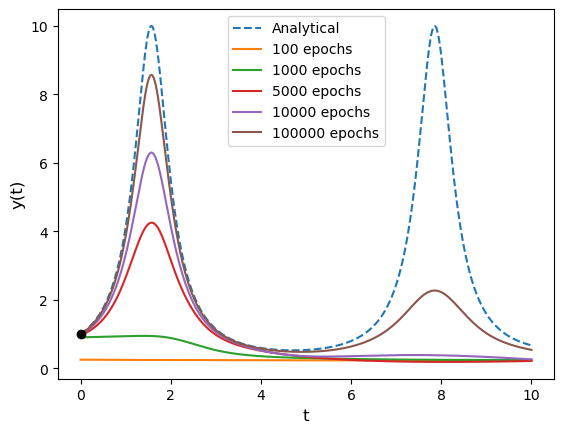

In [32]:
fig, ax = plt.subplots()
epochs_tot = [100, 1000, 5000, 10000, 100000]
def y_sol(ts, t0=torch.tensor([0.0]), y0=torch.tensor([1.0])):
    return 10.0*y0/(10.0-9.0*y0*(torch.sin(ts) - torch.sin(t0)))

ts = torch.linspace(0.0, 10.0, 1000, requires_grad=True)
predictions = [model.forward(x=ts.view(-1,1)) for model in models]
ax.set_xlabel("t", fontsize=12)
ax.set_ylabel("y(t)", fontsize=12)
with torch.no_grad():
    ax.plot(ts, y_sol(ts), "--", label="Analytical")
    for label, prediction in zip(epochs_tot, predictions):
        ax.plot(ts, prediction[0], label=f"{label} epochs")
    for x_dat, y_dat in train_loader:
        ax.plot(x_dat, y_dat, 'o', c="k")
ax.legend()

In [33]:
xs = torch.tensor([1.09491408, 2.04667858, 7.37809938, 8.32986388], dtype=torch.float, requires_grad=True).view(-1,1)
ys = torch.tensor([5.0,5.0,5.0,5.0], dtype=torch.float, requires_grad=True).view(-1,1)
train_data = MyCostumDataset(xs=xs, ys=ys)
train_loader = DataLoader(train_data, batch_size=4)
models = [Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=3, dim_hiddens=4, activation_func=torch.nn.SiLU()) for i in range(5)]

In [34]:
epochs_tot = [100, 1000, 5000, 10000, 100000]

for epochs, model in zip(epochs_tot, models):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    train_diff_model(diff_eq=diff_eq, model=model, train_loader=train_loader, optimizer=optimizer, epochs=epochs)

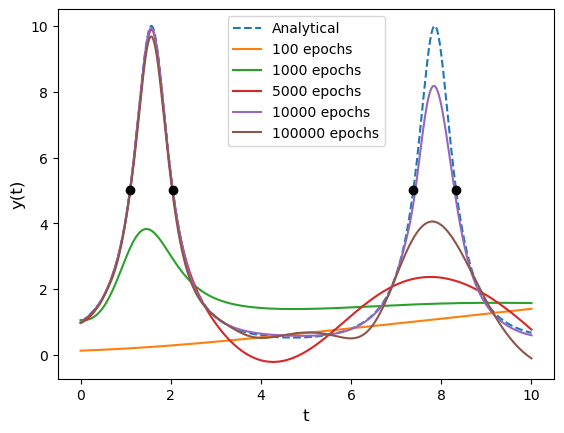

In [35]:
fig, ax = plt.subplots()
epochs_tot = [100, 1000, 5000, 10000, 100000]

ts = torch.linspace(0.0, 10.0, 1000, requires_grad=True)
predictions = [model.forward(x=ts.view(-1,1)) for model in models]
ax.set_xlabel("t", fontsize=12)
ax.set_ylabel("y(t)", fontsize=12)
with torch.no_grad():
    ax.plot(ts, y_sol(ts), "--", label="Analytical")
    for label, prediction in zip(epochs_tot, predictions):
        ax.plot(ts, prediction[0], label=f"{label} epochs")
    for x_dat, y_dat in train_loader:
        ax.plot(x_dat, y_dat, 'o', c="k")
ax.legend()